# CS225 Spatial Computing Project - **TheSparkers**

**Group Members: - 
*  862467107: Vasanth  
*  862467731: Ram  
*  862464481: Deepak  
*  862394968: Aryan Singh  

### installing the required libraries

In [1]:
# !pip install pandas
# !pip install numpy
# !pip install matplotlib
# !pip install scikit-learn

# !pip install flask-ngrok
# !pip install folium
# !pip install pyngrok==4.1.1
# !pip install geopy
# !pip install pgeocode
# !pip install pyspark
# !ngrok authtoken 2LW8p3Ksb3ZgcVmYspmUyJxT9CG_4LBe6cq7uBwg4orRNgW2R

In [2]:
#!pip install seaborn

### importing the basic libraries

In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from flask import Flask, render_template, request, send_from_directory
import folium
from flask_ngrok import run_with_ngrok
import os
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import requests
import geopy
from geopy.geocoders import Nominatim
import pgeocode
nomi = pgeocode.Nominatim('us')
from pyspark import SparkConf, SparkContext
conf = SparkConf() \
    .set("spark.driver.memory", "4g") \
    .set("spark.executor.memory", "4g")
sc = SparkContext(conf=conf)
%matplotlib inline

### loading the realestate_prices dataset

In [4]:
# df = pd.read_csv('realestate_prices.csv')

In [5]:
from pyspark.sql import SparkSession

# Initialize a Spark session
spark = SparkSession.builder \
    .appName("RealEstatePrices") \
    .getOrCreate()

# Read the CSV file into a Spark DataFrame
df = spark.read.csv('realestate_prices.csv', header=True, inferSchema=True)

# Show the DataFrame content (optional)
df.show()

+--------+--------+----------+----------+---------+-----+------------+--------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+----------------

In [6]:
rows = df.head(5)

# Access individual rows
for row in rows:
    print(row)

Row(RegionID=91982, SizeRank=1, RegionName=77494, RegionType='zip', StateName='TX', State='TX', City='Katy', Metro='Houston-The Woodlands-Sugar Land, TX', CountyName='Fort Bend County', 2000-01-31=210998.27485545012, 2000-02-29=211181.402299473, 2000-03-31=211670.74073059086, 2000-04-30=212659.0986891091, 2000-05-31=212694.45208593455, 2000-06-30=212540.12738796184, 2000-07-31=211778.1122460408, 2000-08-31=211810.9460269569, 2000-09-30=211579.9424724476, 2000-10-31=211955.77199162854, 2000-11-30=212821.50835051728, 2000-12-31=213988.64787585937, 2001-01-31=214705.67018640813, 2001-02-28=214410.37816302732, 2001-03-31=213698.04582258395, 2001-04-30=212934.316223686, 2001-05-31=213614.17631609435, 2001-06-30=214880.47307411223, 2001-07-31=216062.0012673007, 2001-08-31=216649.7574406291, 2001-09-30=216560.67512133493, 2001-10-31=216579.48723801642, 2001-11-30=216265.68753533892, 2001-12-31=215519.4971681592, 2002-01-31=214875.22377159365, 2002-02-28=214427.67234202052, 2002-03-31=214835.8

### shape of the dataframe

In [7]:
def get_shape(df):
    return (df.count(), len(df.columns))

print(get_shape(df))

(26368, 294)


### checking for missing values

In [8]:
from pyspark.sql.functions import col, sum as _sum, when

# Count null values for each column
null_counts = df.select([
    _sum(when(col(c).isNull(), 1).otherwise(0)).alias(c)
    for c in df.columns
])

# Show the results
null_counts.show()

+--------+--------+----------+----------+---------+-----+----+-----+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+--------

### dropping all the records with missing values

In [9]:
df = df.dropna()

# Show the updated DataFrame
df.show()

+--------+--------+----------+----------+---------+-----+-------------+--------------------+--------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+-------------

### checking shape of dataframe after dropping records with missing values

In [10]:
get_shape(df)

(10611, 294)

### drop unnecessary columns

In [11]:
# Drop specified columns
new_df = df.drop('RegionID', 'SizeRank', 'RegionType', 'StateName', 'Metro')

# Rename column 'RegionName' to 'zipcode'
new_df = new_df.withColumnRenamed('RegionName', 'zipcode')

# Show the resulting DataFrame
new_df.show()


+-------+-----+-------------+--------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+

### melting the dataframe keeping columns as 'zipcode','CountyName','City','State', 'Date', 'Price'

In [12]:
from pyspark.sql.functions import col, lit, expr

# Columns to keep as id_vars
id_vars = ['zipcode', 'CountyName', 'City', 'State']

# Columns to unpivot
value_vars = [col for col in new_df.columns if col not in id_vars]

# Create the "melted" DataFrame
new_df_melt = new_df.selectExpr(
    *id_vars,
    f"stack({len(value_vars)}, {', '.join([f'\'{col}\', `{col}`' for col in value_vars])}) as (Date, Price)"
)

# Show the resulting DataFrame
new_df_melt.show()

+-------+----------------+----+-----+----------+------------------+
|zipcode|      CountyName|City|State|      Date|             Price|
+-------+----------------+----+-----+----------+------------------+
|  77494|Fort Bend County|Katy|   TX|2000-01-31|210998.27485545012|
|  77494|Fort Bend County|Katy|   TX|2000-02-29|  211181.402299473|
|  77494|Fort Bend County|Katy|   TX|2000-03-31|211670.74073059086|
|  77494|Fort Bend County|Katy|   TX|2000-04-30| 212659.0986891091|
|  77494|Fort Bend County|Katy|   TX|2000-05-31|212694.45208593455|
|  77494|Fort Bend County|Katy|   TX|2000-06-30|212540.12738796184|
|  77494|Fort Bend County|Katy|   TX|2000-07-31| 211778.1122460408|
|  77494|Fort Bend County|Katy|   TX|2000-08-31| 211810.9460269569|
|  77494|Fort Bend County|Katy|   TX|2000-09-30| 211579.9424724476|
|  77494|Fort Bend County|Katy|   TX|2000-10-31|211955.77199162854|
|  77494|Fort Bend County|Katy|   TX|2000-11-30|212821.50835051728|
|  77494|Fort Bend County|Katy|   TX|2000-12-31|

In [13]:
new_df_melt.show(5)

+-------+----------------+----+-----+----------+------------------+
|zipcode|      CountyName|City|State|      Date|             Price|
+-------+----------------+----+-----+----------+------------------+
|  77494|Fort Bend County|Katy|   TX|2000-01-31|210998.27485545012|
|  77494|Fort Bend County|Katy|   TX|2000-02-29|  211181.402299473|
|  77494|Fort Bend County|Katy|   TX|2000-03-31|211670.74073059086|
|  77494|Fort Bend County|Katy|   TX|2000-04-30| 212659.0986891091|
|  77494|Fort Bend County|Katy|   TX|2000-05-31|212694.45208593455|
+-------+----------------+----+-----+----------+------------------+
only showing top 5 rows



### Sort dataset by 'zipcode','CountyName','City','State','Date'

In [14]:
# Sort by the specified columns
new_df_melt_sorted = new_df_melt.orderBy(['zipcode', 'CountyName', 'City', 'State', 'Date'])

# Show the sorted DataFrame
#new_df_melt_sorted.show()

### datatype conversion

In [15]:
from pyspark.sql.functions import to_date, col

# Convert 'Date' column from string to datetime
new_df_melt_sorted = new_df_melt_sorted.withColumn('Date', to_date(col('Date'), 'yyyy-MM-dd'))

# Convert 'zipcode' column from int to string
new_df_melt_sorted = new_df_melt_sorted.withColumn('zipcode', col('zipcode').cast('string'))

# Show the updated DataFrame
new_df_melt_sorted.show()

+-------+--------------+------+-----+----------+------------------+
|zipcode|    CountyName|  City|State|      Date|             Price|
+-------+--------------+------+-----+----------+------------------+
|   1001|Hampden County|Agawam|   MA|2000-01-31|119331.14112240358|
|   1001|Hampden County|Agawam|   MA|2000-02-29|119285.84602957086|
|   1001|Hampden County|Agawam|   MA|2000-03-31|119429.70742235066|
|   1001|Hampden County|Agawam|   MA|2000-04-30|119755.00925334787|
|   1001|Hampden County|Agawam|   MA|2000-05-31|120596.60559883887|
|   1001|Hampden County|Agawam|   MA|2000-06-30|120378.25552882384|
|   1001|Hampden County|Agawam|   MA|2000-07-31|119859.09852186959|
|   1001|Hampden County|Agawam|   MA|2000-08-31|119024.27600129123|
|   1001|Hampden County|Agawam|   MA|2000-09-30|119369.23545371793|
|   1001|Hampden County|Agawam|   MA|2000-10-31|120054.96011924221|
|   1001|Hampden County|Agawam|   MA|2000-11-30|120807.25560529449|
|   1001|Hampden County|Agawam|   MA|2000-12-31|

### extract new features from 'Date'

In [16]:
from pyspark.sql.functions import year, month

# Extract 'Year' from 'Date'
new_df_melt_sorted = new_df_melt_sorted.withColumn('Year', year(col('Date')))

# Extract 'Month' from 'Date'
new_df_melt_sorted = new_df_melt_sorted.withColumn('Month', month(col('Date')))

# Drop the original 'Date' column
new_df_melt_sorted = new_df_melt_sorted.drop('Date')

# Show the resulting DataFrame
new_df_melt_sorted.show()

+-------+--------------+------+-----+------------------+----+-----+
|zipcode|    CountyName|  City|State|             Price|Year|Month|
+-------+--------------+------+-----+------------------+----+-----+
|   1001|Hampden County|Agawam|   MA|119331.14112240358|2000|    1|
|   1001|Hampden County|Agawam|   MA|119285.84602957086|2000|    2|
|   1001|Hampden County|Agawam|   MA|119429.70742235066|2000|    3|
|   1001|Hampden County|Agawam|   MA|119755.00925334787|2000|    4|
|   1001|Hampden County|Agawam|   MA|120596.60559883887|2000|    5|
|   1001|Hampden County|Agawam|   MA|120378.25552882384|2000|    6|
|   1001|Hampden County|Agawam|   MA|119859.09852186959|2000|    7|
|   1001|Hampden County|Agawam|   MA|119024.27600129123|2000|    8|
|   1001|Hampden County|Agawam|   MA|119369.23545371793|2000|    9|
|   1001|Hampden County|Agawam|   MA|120054.96011924221|2000|   10|
|   1001|Hampden County|Agawam|   MA|120807.25560529449|2000|   11|
|   1001|Hampden County|Agawam|   MA| 121544.070

In [17]:
new_df_melt_sorted.printSchema()

root
 |-- zipcode: string (nullable = true)
 |-- CountyName: string (nullable = true)
 |-- City: string (nullable = true)
 |-- State: string (nullable = true)
 |-- Price: double (nullable = true)
 |-- Year: integer (nullable = true)
 |-- Month: integer (nullable = true)



## replacing price

In [18]:
#!pip install setuptools

In [19]:
from pyspark.sql.functions import col, avg
from pyspark.sql.types import IntegerType

# Calculate the mean of 'Price' for each group and replace the 'Price' column
new_df_melt_sorted = new_df_melt_sorted.groupBy(
    'zipcode', 'CountyName', 'City', 'State', 'Year'
).agg(avg('Price').alias('Price'))

# Convert 'Price' from float to int
new_df_melt_sorted = new_df_melt_sorted.withColumn('Price', col('Price').cast(IntegerType()))

# Show the resulting DataFrame
new_df_melt_sorted.show()

+-------+----------------+------------+-----+----+------+
|zipcode|      CountyName|        City|State|Year| Price|
+-------+----------------+------------+-----+----+------+
|   1001|  Hampden County|      Agawam|   MA|2019|214670|
|   1005|Worcester County|       Barre|   MA|2005|234822|
|   1062|Hampshire County| Northampton|   MA|2005|265095|
|   1062|Hampshire County| Northampton|   MA|2014|275317|
|   1077|  Hampden County|   Southwick|   MA|2014|225824|
|   1119|  Hampden County| Springfield|   MA|2007|157607|
|   1222|Berkshire County|   Sheffield|   MA|2014|213548|
|   1240|Berkshire County|       Lenox|   MA|2000|215478|
|   1378| Franklin County|     Warwick|   MA|2000|111405|
|   1420|Worcester County|   Fitchburg|   MA|2019|222416|
|   1469|Middlesex County|    Townsend|   MA|2016|258739|
|   1474|Middlesex County|    Townsend|   MA|2018|301398|
|   1504|Worcester County|  Blackstone|   MA|2015|246368|
|   1532|Worcester County|Northborough|   MA|2007|404892|
|   1537|Worce

In [20]:
new_df_melt_sorted.printSchema()

root
 |-- zipcode: string (nullable = true)
 |-- CountyName: string (nullable = true)
 |-- City: string (nullable = true)
 |-- State: string (nullable = true)
 |-- Year: integer (nullable = true)
 |-- Price: integer (nullable = true)



# EDA

In [21]:
# # Retrieve the first 12 rows as a list of Row objects
# rows = new_df_melt_sorted.head(12)

# # Print each row object
# for row in rows:
#     print(row)

In [22]:
new_df_melt_sorted.printSchema()

root
 |-- zipcode: string (nullable = true)
 |-- CountyName: string (nullable = true)
 |-- City: string (nullable = true)
 |-- State: string (nullable = true)
 |-- Year: integer (nullable = true)
 |-- Price: integer (nullable = true)



In [23]:
from pyspark.sql.functions import avg

# Group by 'State' and calculate the average 'Price'
state_price_avg = new_df_melt_sorted.groupBy('State').agg(avg('Price').alias('AveragePrice'))

# Sort by the average price in ascending order
state_price_avg = state_price_avg.orderBy('AveragePrice')

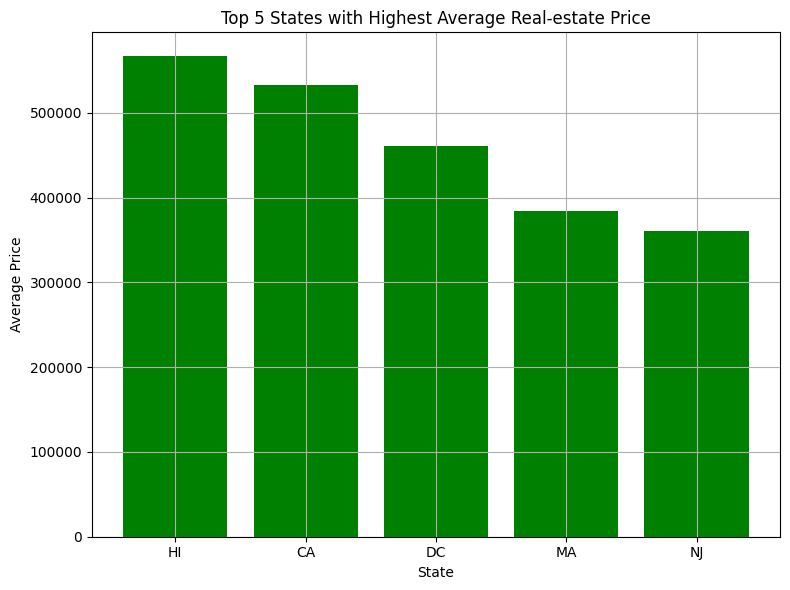

In [24]:
import matplotlib.pyplot as plt
import pandas as pd

# Assuming `state_price_avg` is your Spark DataFrame
# Sort by 'AveragePrice' and get the top 5 states
top_5_highest_avg_price = state_price_avg.orderBy("AveragePrice", ascending=False).limit(5).toPandas()

# Plot the data
plt.figure(figsize=(8, 6))
plt.bar(top_5_highest_avg_price['State'], top_5_highest_avg_price['AveragePrice'], color='green')
plt.title('Top 5 States with Highest Average Real-estate Price')
plt.ylabel('Average Price')
plt.xlabel('State')
plt.grid()
plt.tight_layout()
plt.show()

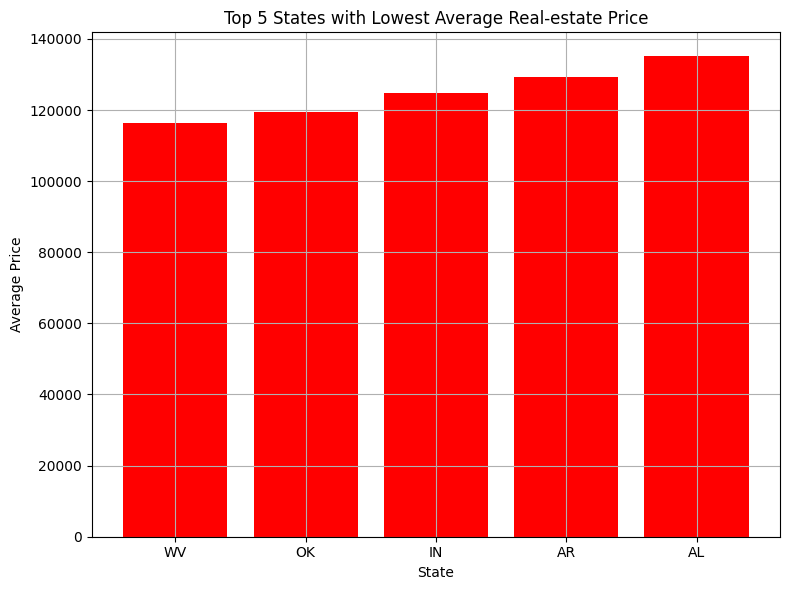

In [25]:
from pyspark.sql.functions import col
import matplotlib.pyplot as plt

# Sort the DataFrame by 'AveragePrice' in ascending order and take the top 5
top_5_lowest_avg_price = state_price_avg.orderBy(col("AveragePrice").asc()).limit(5).toPandas()

# Plot the data using Matplotlib
plt.figure(figsize=(8, 6))
plt.bar(top_5_lowest_avg_price['State'], top_5_lowest_avg_price['AveragePrice'], color='red')
plt.title('Top 5 States with Lowest Average Real-estate Price')
plt.ylabel('Average Price')
plt.xlabel('State')
plt.grid()
plt.tight_layout()
plt.show()

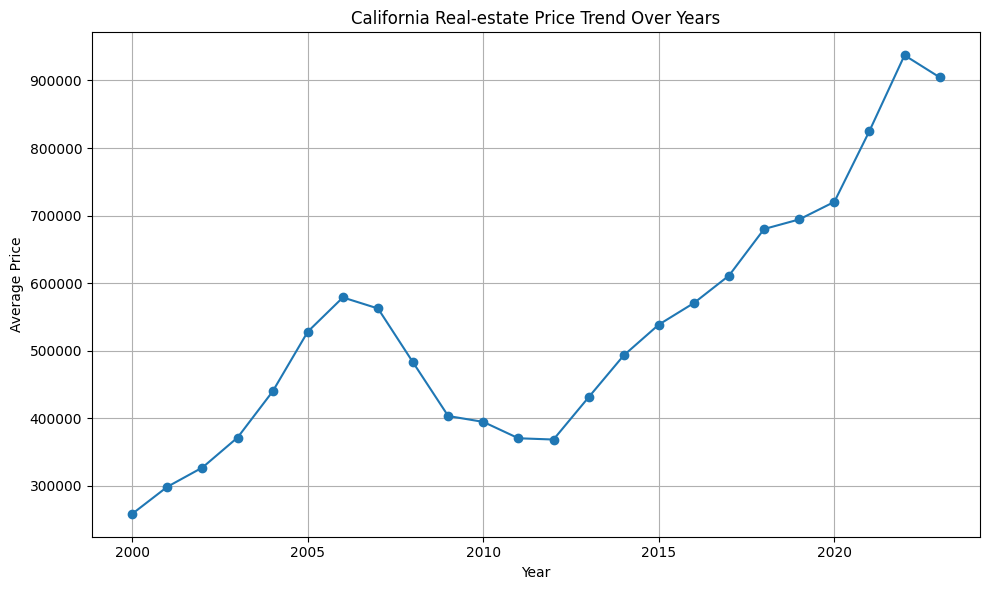

In [26]:
from pyspark.sql.functions import col, mean

# Filter data for California
ca_data = new_df_melt_sorted.filter(col("State") == "CA")

# Group by Year and calculate the mean Price
avg_price_per_year = ca_data.groupBy("Year").agg(mean("Price").alias("AveragePrice")).orderBy("Year")

# Convert to Pandas for plotting
avg_price_per_year_pd = avg_price_per_year.toPandas()

# Plot the trend using Matplotlib
import matplotlib.pyplot as plt

avg_price_per_year_pd.plot(x="Year", y="AveragePrice", figsize=(10, 6), marker='o', legend=False)

# Add title, labels, and grid
plt.title('California Real-estate Price Trend Over Years')
plt.ylabel('Average Price')
plt.xlabel('Year')
plt.grid()
plt.tight_layout()
plt.show()

# Linear Regression

In [27]:
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score
import pandas as pd

# Convert PySpark DataFrame to Pandas DataFrame
new_df_pandas = new_df_melt_sorted.toPandas()

# Define independent and dependent variables
X = new_df_pandas[['zipcode', 'CountyName', 'City', 'State', 'Year']]  # independent features
y = new_df_pandas['Price']  # dependent feature

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

# Preprocessing: encode categorical features and scale numerical features
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(), ['zipcode', 'CountyName', 'City', 'State']),
        ('num', StandardScaler(), ['Year'])
    ])

# Build a pipeline with preprocessing and a linear regression model
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', LinearRegression())  # using linear regression
])

# Train the model
pipeline.fit(X_train, y_train)

# Predict on the test set
y_pred = pipeline.predict(X_test)

# Evaluate the model
r2 = round(r2_score(y_test, y_pred), 2)
print(f'R-squared: {r2}')

R-squared: 0.85


## predict_price

## predict_price

In [28]:
def predict_price(zipcode, year):
    '''
    Predicts price based on the user-entered zipcode and year.
    '''
    # Filter details for the given zipcode
    zip_code_details = new_df_melt_sorted.filter(
        new_df_melt_sorted['zipcode'] == zipcode
    ).collect()

    if not zip_code_details:
        return "No data available for the given zipcode."

    # Extract city, county, state from the first row
    first_row = zip_code_details[0]
    city = first_row.City
    county_name = first_row.CountyName
    state = first_row.State

    # Prepare input DataFrame for the model
    user_input = pd.DataFrame({
        'zipcode': [zipcode],
        'CountyName': [county_name],
        'City': [city],
        'State': [state],
        'Year': [year]
    })

    # Encode input and predict price
    user_input_encoded = pipeline.named_steps['preprocessor'].transform(user_input)
    predicted_price = pipeline.named_steps['model'].predict(user_input_encoded)

    return int(predicted_price[0])


## Analysis on Zipcodes of States

In [46]:
def map_expensive_zipcodes(data, year):
    '''
    This function is used to return Top 5 expensive zipcodes
    for a given state in a partuclar year
    '''
    year_data = data[data['Year'] == year]
    zipcode_prices = year_data.groupby(['State', 'zipcode'])['Price'].mean().reset_index()
    geolocator = pgeocode.Nominatim('us')
    def get_zip_info(zip_code):
        formatted_zip = str(zip_code).zfill(5)
        location = geolocator.query_postal_code(formatted_zip)
        if location is None or pd.isnull(location.latitude) or pd.isnull(location.longitude):
            return None, None
        return [location.latitude, location.longitude], location.place_name

    folium_map = folium.Map(location=[30.0902, -95.7129], zoom_start=3.5)  # Center of the USA

    def add_markers(state, zip_data, color):
        '''
        Adds markers to the zip codes in the state
        '''
        for _, row in zip_data.iterrows():
            coordinates, city_name = get_zip_info(row['zipcode'])
            if coordinates:
                popup_text = f"{state} Zip: {row['zipcode']}, City: {city_name}, Price: ${row['Price']}"
                folium.Marker(
                    location=coordinates,
                    popup=popup_text,
                    icon=folium.Icon(color=color)
                ).add_to(folium_map)

    for state in year_data['State'].unique():
        state_data = zipcode_prices[zipcode_prices['State'] == state]
        top_zipcode = state_data.nlargest(1, 'Price')
        bottom_zipcode = state_data.nsmallest(1, 'Price')
        add_markers(state, top_zipcode, 'red')
        add_markers(state, bottom_zipcode, 'blue')

    return folium_map

def map_zipcode_prices(data, year, state):
    """
    Map the top 5 expensive and affordable zip codes within a state for a given year.
    """
    # Filter for the given year and state
    year_state_data = data.filter((data['Year'] == year) & (data['State'] == state))

    # Compute average prices by zip code
    zipcode_prices = (
        year_state_data.groupBy("zipcode")
        .agg(F.mean("Price").alias("AveragePrice"))
        .orderBy("AveragePrice")
    )

    # Collect data for top and bottom zip codes
    top_zipcodes = zipcode_prices.orderBy(F.desc("AveragePrice")).limit(5).collect()
    bottom_zipcodes = zipcode_prices.orderBy("AveragePrice").limit(5).collect()

    geolocator = pgeocode.Nominatim('us')

    def get_lat_long(zip_code):
        formatted_zip = str(zip_code).zfill(5)
        location = geolocator.query_postal_code(formatted_zip)
        if location is None or pd.isnull(location.latitude) or pd.isnull(location.longitude):
            return None, None
        city_name = location.place_name
        return [location.latitude, location.longitude], city_name

    # Create Folium map centered on the state
    first_zip_location, _ = get_lat_long(top_zipcodes[0]['zipcode'])
    folium_map = folium.Map(location=first_zip_location, zoom_start=7)

    # Helper to add markers
    def add_markers(zipcode_data, color):
        for row in zipcode_data:
            coordinates, city_name = get_lat_long(row['zipcode'])
            if coordinates:
                popup_text = f"Zipcode: {row['zipcode']}, City: {city_name}, Average Price: ${row['AveragePrice']:.2f}"
                folium.Marker(
                    location=coordinates,
                    popup=popup_text,
                    icon=folium.Icon(color=color)
                ).add_to(folium_map)

    add_markers(top_zipcodes, 'red')
    add_markers(bottom_zipcodes, 'green')

    return folium_map

def get_geojson(url):
    response = requests.get(url)
    if response.status_code == 200:
        return response.json()
    else:
        raise Exception("Failed to download GeoJSON data")

def add_state_markers(map_object, states_data, state_coords):
    """
    Add markers to the map for each state with the average price as a popup.
    """
    for _, row in states_data.iterrows():
        state_name = row['State']
        location = state_coords.get(state_name)
        if location:
            folium.Marker(
                location=location,
                popup=f"{state_name}: ${row['AveragePrice']:.2f}",
                icon=folium.Icon(color="blue", icon="info-sign")
            ).add_to(map_object)



from pyspark.sql import functions as F

def create_choropleth_map(data, year, geojson, state_coords):
    """
    Creates a choropleth map for the given year using PySpark and Folium.
    """
    # Filter the data for the given year
    data_for_year = data.filter(data['Year'] == year)

    # Group by 'State', calculate the mean price, and collect the results
    average_prices = (
        data_for_year.groupBy('State')
        .agg(F.mean('Price').alias('AveragePrice'))
        .orderBy('AveragePrice', ascending=False)
    )

    # Convert the result to Pandas for visualization
    average_prices_pandas = average_prices.toPandas()

    # Create a Folium map centered in the USA
    m = folium.Map(location=[37.0902, -95.7129], zoom_start=4)

    # Add a Choropleth layer
    folium.Choropleth(
        geo_data=geojson,
        name="choropleth",
        data=average_prices_pandas,
        columns=["State", "AveragePrice"],
        key_on="feature.id",
        fill_color="YlGn",
        fill_opacity=0.7,
        line_opacity=0.1,
        legend_name="Average House Price"
    ).add_to(m)

    # Handle special case for DC
    dc_data = average_prices_pandas[average_prices_pandas['State'] == 'DC']
    if not dc_data.empty:
        dc_price = dc_data.iloc[0]['AveragePrice']
        folium.CircleMarker(
            location=[38.9072, -77.0369],  # DC coordinates
            radius=5,
            color='red',
            fill=True,
            fill_color='red',
            fill_opacity=0.7,
            popup=f"DC: ${dc_price:.2f}"
        ).add_to(m)

    # Add state markers
    add_state_markers(m, average_prices_pandas, state_coords)

    # Add layer control
    folium.LayerControl().add_to(m)

    return m



# Analysis on States of USA

In [49]:
def add_boundary_data(state, folium_map, price):
    '''
    Add boundary for the given state and create a marker with price value as popup.
    '''
    base_url = 'https://nominatim.openstreetmap.org/search'
    params = {
        'state': state,
        'country': 'US',
        'format': 'json',
        'polygon_geojson': 1,
        'feature_type': 'state'
    }

    response = requests.get(base_url, params=params)

    if response.status_code != 200 or not response.json():
        print(f"Failed to fetch data for state: {state}")
        return

    city_boundary_data = response.json()[0]
    geo_json = city_boundary_data.get('geojson')
    lat, lon = city_boundary_data.get('lat'), city_boundary_data.get('lon')

    if not geo_json or not lat or not lon:
        print(f"Incomplete GeoJSON data for state: {state}")
        return

    folium.GeoJson(
        geo_json, 
        name='state_boundary',
        style_function=lambda x: {
            'color': 'blue',
            'fillOpacity': 0.2,
            'weight': 2
        }
    ).add_to(folium_map)

    folium.Marker(
        [float(lat), float(lon)],
        popup=f"<b>${int(price)}</b>",
        icon=folium.Icon(color="red", icon="info-sign")
    ).add_to(folium_map)

def get_state_full_names(abbreviations):
    ''' 
    Converts given state abbrivation into 
    complete state name
    '''
    
    states = {
    'AL': 'Alabama', 'AK': 'Alaska', 'AZ': 'Arizona', 'AR': 'Arkansas',
    'CA': 'California', 'CO': 'Colorado', 'CT': 'Connecticut', 'DE': 'Delaware',
    'FL': 'Florida', 'GA': 'Georgia', 'HI': 'Hawaii', 'ID': 'Idaho',
    'IL': 'Illinois', 'IN': 'Indiana', 'IA': 'Iowa', 'KS': 'Kansas',
    'KY': 'Kentucky', 'LA': 'Louisiana', 'ME': 'Maine', 'MD': 'Maryland',
    'MA': 'Massachusetts', 'MI': 'Michigan', 'MN': 'Minnesota', 'MS': 'Mississippi',
    'MO': 'Missouri', 'MT': 'Montana', 'NE': 'Nebraska', 'NV': 'Nevada',
    'NH': 'New Hampshire', 'NJ': 'New Jersey', 'NM': 'New Mexico', 'NY': 'New York',
    'NC': 'North Carolina', 'ND': 'North Dakota', 'OH': 'Ohio', 'OK': 'Oklahoma',
    'OR': 'Oregon', 'PA': 'Pennsylvania', 'RI': 'Rhode Island', 'SC': 'South Carolina',
    'SD': 'South Dakota', 'TN': 'Tennessee', 'TX': 'Texas', 'UT': 'Utah',
    'VT': 'Vermont', 'VA': 'Virginia', 'WA': 'Washington', 'WV': 'West Virginia',
    'WI': 'Wisconsin', 'WY': 'Wyoming', 'DC': 'District of Columbia'
}   
    return states.get(abbreviations, "Unknown")

def get_top_5_states(year):
    '''
    Return top 5 expensive states for a given year as a Pandas DataFrame.
    '''
    data_for_year = new_df_melt_sorted.filter(new_df_melt_sorted['Year'] == year)

    if data_for_year.count() == 0:
        print(f"No data available for year: {year}")
        return pd.DataFrame(columns=['State', 'AveragePrice'])

    top_5_states = (
        data_for_year.groupBy('State')
        .agg(F.mean('Price').alias('AveragePrice'))
        .orderBy('AveragePrice', ascending=False)
        .limit(5)
    )

    return top_5_states.toPandas()


def get_affordable_5_states(year):
    '''
    Return top 5 affordable states in the USA for the given year.
    '''
    data_for_year = new_df_melt_sorted.filter(new_df_melt_sorted['Year'] == year)

    if data_for_year.count() == 0:
        print(f"No data available for year: {year}")
        return pd.DataFrame(columns=['State', 'AveragePrice'])

    affordable_5_states = (
        data_for_year.groupBy('State')
        .agg(F.mean('Price').alias('AveragePrice'))
        .orderBy('AveragePrice', ascending=True)
        .limit(5)
    )

    return affordable_5_states.toPandas()



def map_affordable_states(year):
    '''
    Maps the affordable states data to the Folium map by adding 
    a boundary and marker to the geojson data from Nominatim OSM API.
    '''
    affordable_5_states = get_affordable_5_states(year)

    if affordable_5_states.empty:
        print(f"No affordable states data for year: {year}")
        return folium.Map(location=[30.0902, -95.7129], zoom_start=3.5)  # Default empty map

    folium_map = folium.Map(location=[30.0902, -95.7129], zoom_start=3.5)  # Center of the USA

    for _, row in affordable_5_states.iterrows():
        state = row['State']
        avg_price = row['AveragePrice']
        add_boundary_data(get_state_full_names(state), folium_map, avg_price)

    return folium_map


def map_expensive_states(year):
    '''
    Map the most expensive states with boundaries and markers.
    '''
    top_5_states = get_top_5_states(year)

    if top_5_states.empty:
        print(f"No data to map for year: {year}")
        return folium.Map(location=[30.0902, -95.7129], zoom_start=3.5)

    folium_map = folium.Map(location=[30.0902, -95.7129], zoom_start=3.5)

    for _, row in top_5_states.iterrows():
        state = row['State']
        avg_price = row['AveragePrice']
        add_boundary_data(get_state_full_names(state), folium_map, avg_price)

    return folium_map

# Sparkers - App

In [50]:
app = Flask(__name__)
run_with_ngrok(app)

os.makedirs('temp', exist_ok=True)

def get_ml_model_output(zipcode, year):
    '''
    gets the model predictions for given zipcode 
    and year using the trainer linear regression model.
    '''
    
    prediction = predict_price(zipcode,year)
    return f"Zipcode: {zipcode}\nYear: {year}\nPredicted Price: ${prediction}"

def add_boundary_data(state, folium_map, price):
    '''
    Adds state boundary and price marker to the map.
    '''
    try:
        response = requests.get(
            'https://nominatim.openstreetmap.org/search',
            params={
                'state': state,
                'country': 'US',
                'format': 'json',
                'polygon_geojson': 1
            }
        )
        response.raise_for_status()
        geo_data = response.json()
        
        if geo_data:
            # Extract latitude, longitude, and boundary data
            location = geo_data[0]
            lat, lon = location['lat'], location['lon']
            geo_json = location['geojson']
            
            # Add GeoJSON layer
            folium.GeoJson(geo_json, style_function=lambda x: {
                'fillColor': 'blue', 'color': 'blue', 'fillOpacity': 0.2
            }).add_to(folium_map)
            
            # Add Marker
            folium.Marker(
                [lat, lon],
                popup=f"<b>${price:.2f}</b>",
                icon=folium.Icon(color="red", icon="info-sign")
            ).add_to(folium_map)
    except Exception as e:
        print(f"Error adding boundary for {state}: {e}")


    

@app.route('/', methods=['GET', 'POST'])
def index():
    return render_template('index.html')

@app.route('/temp/<filename>')
def temp_file(filename):
    return send_from_directory('temp', filename)

@app.route('/predictions', methods=['GET', 'POST'])
def predictions():
    map_html_file = None
    if request.method == 'POST':
        zipcode = request.form.get('zipcode')
        year = request.form.get('year')
        query = nomi.query_postal_code(zipcode)
        latitude = query['latitude']
        longitude = query['longitude']
        folium_map = folium.Map(location=[latitude, longitude], zoom_start=12)
        folium.Marker([latitude, longitude], popup=get_ml_model_output(zipcode, year)).add_to(folium_map)
        map_html_file = 'temp/map.html'
        folium_map.save(map_html_file)

    return render_template('/prediction.html', map_html_file=map_html_file)

@app.route('/analysis', methods=['GET', 'POST'])
def analysis():
    print("Accessing the analysis page")  # Debugging print
    analysis_content = "Select an option to view the map analysis."
    map_html_file = None

    if request.method == 'POST':
        year = int(request.form.get('year'))
        map_choice = request.form.get('map_choice')
        state = request.form.get('state') if map_choice == 'state_zipcodes' else None

        if map_choice == 'expensive_zipcodes':
                folium_map = map_expensive_zipcodes(new_df_melt_sorted, year)
                map_html_file = 'expensive_zipcodes_map.html'
                folium_map.save(f'temp/{map_html_file}')
        
        elif map_choice == 'expensive_states':
                folium_map = map_expensive_states(year)
                map_html_file = 'expensive_states_map.html'
                folium_map.save(f'temp/{map_html_file}')
        
        elif map_choice == 'affordable_states':
                folium_map = map_affordable_states(year)
                map_html_file = 'affordable_states_map.html'
                folium_map.save(f'temp/{map_html_file}')
                
        elif map_choice == 'state_zipcodes' and state:
                folium_map = map_zipcode_prices(new_df_melt_sorted, year, state)
                map_html_file = 'state_zipcodes_map.html'
                folium_map.save(f'temp/{map_html_file}')
        elif map_choice == 'choropleth_map':
                url = "https://raw.githubusercontent.com/python-visualization/folium/main/examples/data/us-states.json"
                geojson = get_geojson(url)
                state_coords = {
                    'AL': [32.806671, -86.791130], 'AK': [61.370716, -152.404419], 'AZ': [33.729759, -111.431221],
                    'AR': [34.969704, -92.373123], 'CA': [36.116203, -119.681564], 'CO': [39.059811, -105.311104],
                    'CT': [41.597782, -72.755371], 'DE': [39.318523, -75.507141], 'FL': [27.766279, -81.686783],
                    'GA': [33.040619, -83.643074], 'HI': [21.094318, -157.498337], 'ID': [44.240459, -114.478828],
                    'IL': [40.349457, -88.986137], 'IN': [39.849426, -86.258278], 'IA': [42.011539, -93.210526],
                    'KS': [38.526600, -96.726486], 'KY': [37.668140, -84.670067], 'LA': [31.169546, -91.867805],
                    'ME': [44.693947, -69.381927], 'MD': [39.063946, -76.802101], 'MA': [42.230171, -71.530106],
                    'MI': [43.326618, -84.536095], 'MN': [45.694454, -93.900192], 'MS': [32.741646, -89.678696],
                    'MO': [38.456085, -92.288368], 'MT': [46.921925, -110.454353], 'NE': [41.125370, -98.268082],
                    'NV': [38.313515, -117.055374], 'NH': [43.452492, -71.563896], 'NJ': [40.298904, -74.521011],
                    'NM': [34.840515, -106.248482], 'NY': [42.165726, -74.948051], 'NC': [35.630066, -79.806419],
                    'ND': [47.528912, -99.784012], 'OH': [40.388783, -82.764915], 'OK': [35.565342, -96.928917],
                    'OR': [44.572021, -122.070938], 'PA': [40.590752, -77.209755], 'RI': [41.680893, -71.511780],
                    'SC': [33.856892, -80.945007], 'SD': [44.299782, -99.438828], 'TN': [35.747845, -86.692345],
                    'TX': [31.054487, -97.563461], 'UT': [40.150032, -111.862434], 'VT': [44.045876, -72.710686],
                    'VA': [37.769337, -78.169968], 'WA': [47.400902, -121.490494], 'WV': [38.491226, -80.954570],
                    'WI': [44.268543, -89.616508], 'WY': [42.755966, -107.302490], 'DC': [38.897438, -77.026817]
                }
                folium_map = create_choropleth_map(new_df_melt_sorted, year, geojson, state_coords)
                map_html_file = 'choropleth_map.html'
                folium_map.save(f'temp/{map_html_file}')

    if map_html_file:
            folium_map.save(map_html_file)

    return render_template('analysis.html', analysis_content=analysis_content, map_html_file=map_html_file)

if __name__ == '__main__':
    app.run()


 * Serving Flask app '__main__'
 * Debug mode: off


 * Running on http://127.0.0.1:5000
Press CTRL+C to quit
Exception in thread Thread-79:
Traceback (most recent call last):
  File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.13_3.13.496.0_x64__qbz5n2kfra8p0\Lib\threading.py", line 1041, in _bootstrap_inner
    self.run()
    ~~~~~~~~^^
  File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.13_3.13.496.0_x64__qbz5n2kfra8p0\Lib\threading.py", line 1342, in run
    self.function(*self.args, **self.kwargs)
    ~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\aryan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\flask_ngrok.py", line 70, in start_ngrok
    ngrok_address = _run_ngrok()
  File "C:\Users\aryan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\flask_ngrok.py", line 36, in _run_ngrok
    j = json.loads(tunnel_url)
  File "C:\Program File

Accessing the analysis page
Accessing the analysis page
Error adding boundary for Hawaii: 403 Client Error: Forbidden for url: https://nominatim.openstreetmap.org/search?state=Hawaii&country=US&format=json&polygon_geojson=1
Error adding boundary for California: 403 Client Error: Forbidden for url: https://nominatim.openstreetmap.org/search?state=California&country=US&format=json&polygon_geojson=1
Error adding boundary for District of Columbia: 403 Client Error: Forbidden for url: https://nominatim.openstreetmap.org/search?state=District+of+Columbia&country=US&format=json&polygon_geojson=1
Error adding boundary for Massachusetts: 403 Client Error: Forbidden for url: https://nominatim.openstreetmap.org/search?state=Massachusetts&country=US&format=json&polygon_geojson=1


127.0.0.1 - - [09/Dec/2024 20:58:06] "POST /analysis HTTP/1.1" 200 -


Error adding boundary for New Jersey: 403 Client Error: Forbidden for url: https://nominatim.openstreetmap.org/search?state=New+Jersey&country=US&format=json&polygon_geojson=1


127.0.0.1 - - [09/Dec/2024 20:58:06] "GET /temp/expensive_states_map.html HTTP/1.1" 200 -
127.0.0.1 - - [09/Dec/2024 20:58:14] "POST /analysis HTTP/1.1" 200 -


Accessing the analysis page


[2024-12-09 20:58:21,282] ERROR in app: Exception on /analysis [POST]
Traceback (most recent call last):
  File "C:\Users\aryan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\flask\app.py", line 1511, in wsgi_app
    response = self.full_dispatch_request()
  File "C:\Users\aryan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\flask\app.py", line 919, in full_dispatch_request
    rv = self.handle_user_exception(e)
  File "C:\Users\aryan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\flask\app.py", line 917, in full_dispatch_request
    rv = self.dispatch_request()
  File "C:\Users\aryan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\flask\app.py", line 902, in dispatch_request
    retu

Accessing the analysis page
